# Overview

Testing different versions of NB, by applying TF, CountVectorizer, ROS.



In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, balanced_accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import pandas as pd
from src.utils import load_cleaned_data, split, metrics, store_metrics, plot_confusion_matrix

# Adding both TF and CountVectorizer

* CountVectorizer() → raw word counts

* TfidfVectorizer() → weighted terms


In [ ]:
def tfidf(X_train, X_test):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    return X_train_tfidf, X_test_tfidf

def count_vectorizer(X_train, X_test):
    vectorizer = CountVectorizer(stop_words='english', max_features=10000)
    X_train_counts = vectorizer.fit_transform(X_train)
    X_test_counts = vectorizer.transform(X_test)
    return X_train_counts, X_test_counts

In [ ]:
# Uses MultinomialNB for the baseline model
def naive_bayes(X_train_tfidf, X_test_tfidf, y_train):
  model = MultinomialNB()
  model.fit(X_train_tfidf, y_train)
  y_pred = model.predict(X_test_tfidf)
  return model, y_pred

# Comparison approach: TF & CountVect
1. Store the evaluation scores for both methods instead of just printing them.

2. Compare the results (e.g., based on F1-score or AUC, depending on what you value more).



--- Naive Bayes with TF-IDF ---
Accuracy: 0.65
Balanced Accuracy: 0.54
Precision: 0.80
Recall: 0.08
F1: 0.15
AUC: 0.75


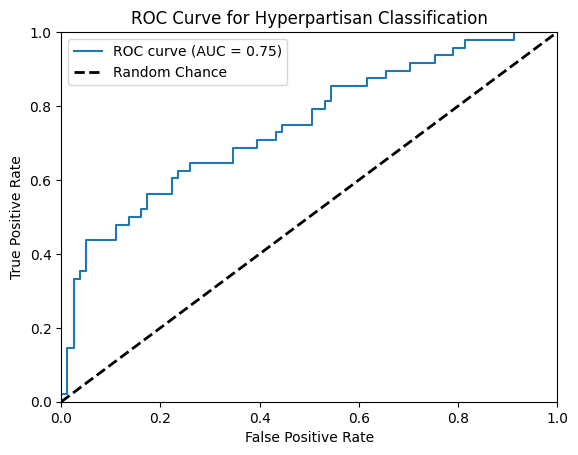

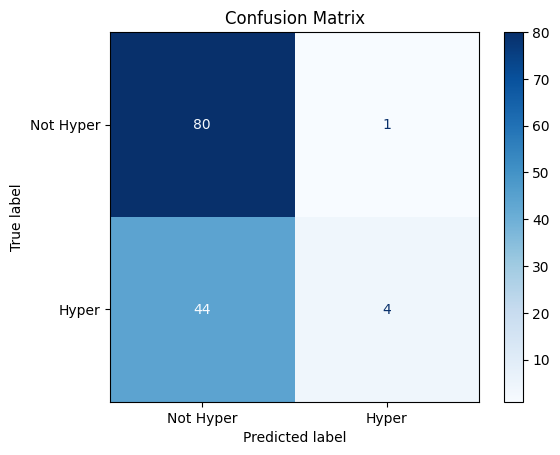


--- Naive Bayes with CountVectorizer ---
Accuracy: 0.69
Balanced Accuracy: 0.69
Precision: 0.57
Recall: 0.71
F1: 0.63
AUC: 0.77


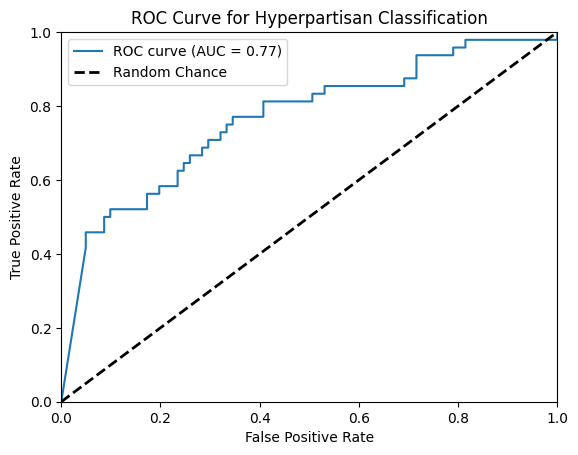

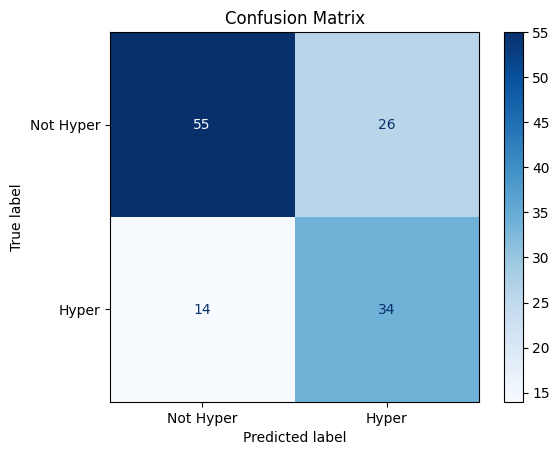


=== Final Comparison Table ===
         Model            Setup  Accuracy  Balanced Accuracy  Precision  Recall  F1 Score    AUC
0  Naive Bayes           TF-IDF     0.651              0.535      0.800   0.083     0.151  0.746
1  Naive Bayes  CountVectorizer     0.690              0.694      0.567   0.708     0.630  0.765


In [ ]:
# Load the data
data = load_cleaned_data("data/byarticle_clean.tsv") #../
X = data['full_text']
y = data['label']

# Split the data
X_train, X_test, y_train, y_test = split(X, y)

# Store results for summary
results = []

# Vectorization methods
vectorizers = {
    "TF-IDF": tfidf,
    "CountVectorizer": count_vectorizer
}

# Run Naive Bayes for each vectorizer
for vec_name, vectorizer_fn in vectorizers.items():
    X_train_vec, X_test_vec = vectorizer_fn(X_train, X_test)
    model, y_pred = naive_bayes(X_train_vec, X_test_vec, y_train)
    y_proba = model.predict_proba(X_test_vec)[:, 1]

    print(f"\n--- Naive Bayes with {vec_name} ---")
    metrics(y_test, y_pred, y_proba)  # Prints + ROC curve
    plot_confusion_matrix(y_test, y_pred)

    setup_label = f"{vec_name}"
    store_metrics(results, model_name="Naive Bayes", setup_label=setup_label, y_test=y_test, y_pred=y_pred, y_pred_proba=y_proba)


results_df = pd.DataFrame(results)
print("\n=== Comparison Table ===")
print(results_df)


As seen from the table, TF-IDf is not a good fit for NB.

# Testing with ROS

resusing prev. functions.


In [ ]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, roc_auc_score


=== Naive Bayes with TF-IDF + ROS ===
              precision    recall  f1-score   support

           0       0.84      0.47      0.60        81
           1       0.49      0.85      0.62        48

    accuracy                           0.61       129
   macro avg       0.67      0.66      0.61       129
weighted avg       0.71      0.61      0.61       129

Accuracy: 0.61
Balanced Accuracy: 0.66
Precision: 0.49
Recall: 0.85
F1: 0.62
AUC: 0.81


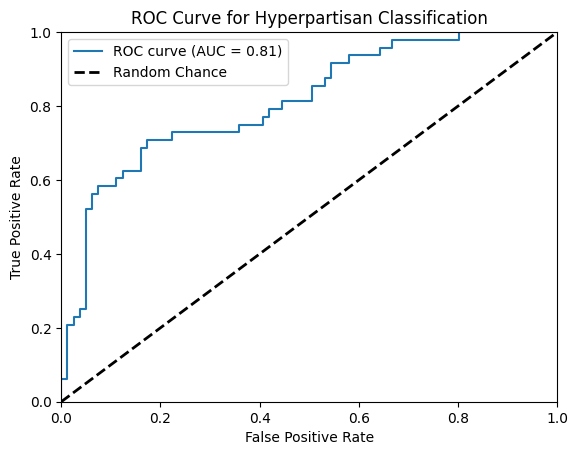

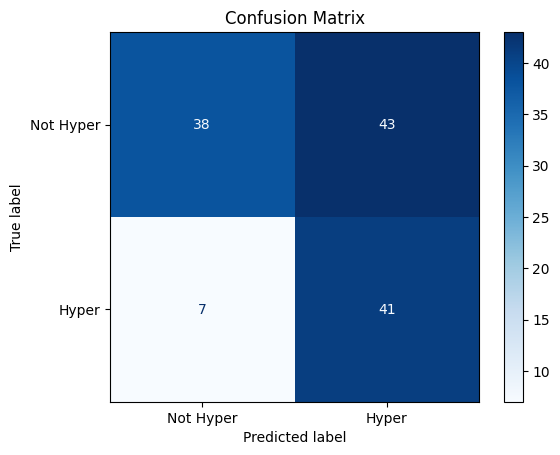


=== Naive Bayes with CountVectorizer + ROS ===
              precision    recall  f1-score   support

           0       0.82      0.73      0.77        81
           1       0.61      0.73      0.67        48

    accuracy                           0.73       129
   macro avg       0.72      0.73      0.72       129
weighted avg       0.74      0.73      0.73       129

Accuracy: 0.73
Balanced Accuracy: 0.73
Precision: 0.61
Recall: 0.73
F1: 0.67
AUC: 0.77


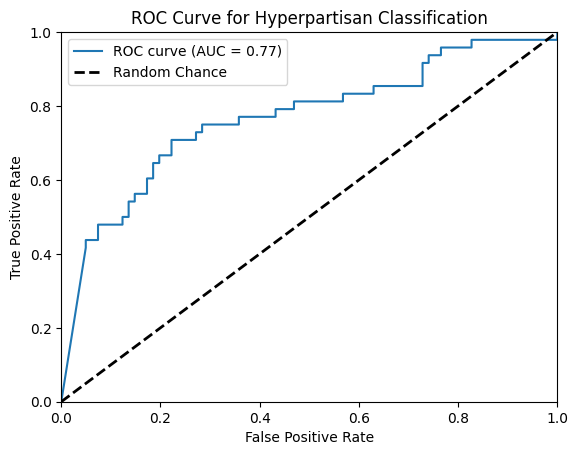

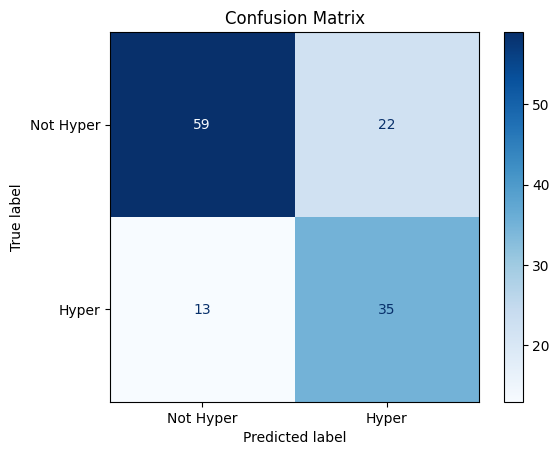


=== Comparison Table ===
         Model                  Setup  Accuracy  ...  Recall  F1 Score    AUC
0  Naive Bayes                 TF-IDF     0.651  ...   0.083     0.151  0.746
1  Naive Bayes        CountVectorizer     0.690  ...   0.708     0.630  0.765
2  Naive Bayes           TF-IDF + ROS     0.612  ...   0.854     0.621  0.811
3  Naive Bayes  CountVectorizer + ROS     0.729  ...   0.729     0.667  0.768

[4 rows x 8 columns]


In [ ]:
for vec_name, vectorizer_fn in vectorizers.items():
    # Vectorize train/test
    X_train_vec, X_test_vec = vectorizer_fn(X_train, X_test)

    # Apply Random OverSampler
    ros = RandomOverSampler(random_state=0)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train_vec, y_train)

    # Train Naive Bayes
    model, y_pred = naive_bayes(X_train_resampled, X_test_vec, y_train_resampled)
    y_proba = model.predict_proba(X_test_vec)[:, 1]

    print(f"\n=== Naive Bayes with {vec_name} + ROS ===")
    print(classification_report(y_test, y_pred))
    metrics(y_test, y_pred, y_proba)
    plot_confusion_matrix(y_test, y_pred)

    # Store clean setup label for table
    setup_label = f"{vec_name} + ROS"
    store_metrics(results, "Naive Bayes", setup_label, y_test, y_pred, y_proba)

# Summary table
results_df = pd.DataFrame(results)
print("\n=== Comparison Table ===")
print(results_df)

# Analyze after improved with ROS

Huge improvement for both methods (especially TF-IDF).
F1 Score: Big jump — from almost unusable (0.151) to competitive (0.621/0.667).

AUC: Improved — especially TF-IDF (+0.065), showing the model now captures more of the signal.

Balanced performance: Models are no longer biased toward the majority class.

**What decreased?**

F-IDF Accuracy dropped slightly (from 0.651 ➝ 0.612)

    That’s expected: more false positives, but better coverage.

Precision dropped in TF-IDF + ROS (from 0.800 ➝ 0.488)

    Model is now less “conservative” and predicts more 1s.


We can summorize:

TF-IDF -> High precision, but misses almost all hyperpartisan articles

CountVectorizer -> Balanced but modest

TF-IDF + ROS ->  Best at catching hyperpartisan articles, even if precision drops

CountVec + ROS -> Best overall balance of all metrics


# Adding styling

In [ ]:
style_features = ['uppercase_ratio', 'exclamation_count', 'avg_sentence_length']
style_data = data[style_features]

In [ ]:
from scipy.sparse import hstack
from sklearn.preprocessing import MinMaxScaler


def combine_text_and_style(vectorizer_fn, X_train_text, X_test_text, X_train_style, X_test_style):
    # Vectorize text
    X_train_vec = vectorizer_fn.fit_transform(X_train_text)
    X_test_vec = vectorizer_fn.transform(X_test_text)

    # Scale numeric style features
    scaler = MinMaxScaler()
    X_train_style_scaled = scaler.fit_transform(X_train_style)
    X_test_style_scaled = scaler.transform(X_test_style)

    # Convert to sparse matrices
    from scipy.sparse import csr_matrix
    X_train_style_sparse = csr_matrix(X_train_style_scaled)
    X_test_style_sparse = csr_matrix(X_test_style_scaled)

    # Combine
    X_train_combined = hstack([X_train_vec, X_train_style_sparse])
    X_test_combined = hstack([X_test_vec, X_test_style_sparse])

    print("Text vector shape:", X_train_vec.shape)
    print("Style vector shape:", X_train_style_sparse.shape)
    print("Combined shape:", X_train_combined.shape)


    return X_train_combined, X_test_combined


Text vector shape: (516, 10000)
Style vector shape: (516, 3)
Combined shape: (516, 10003)

--- Naive Bayes + CountVectorizer + Style + ROS ---
Accuracy: 0.73
Balanced Accuracy: 0.73
Precision: 0.61
Recall: 0.73
F1: 0.67
AUC: 0.77


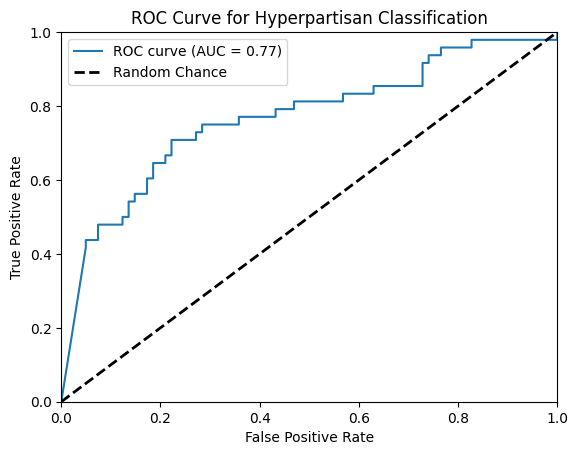

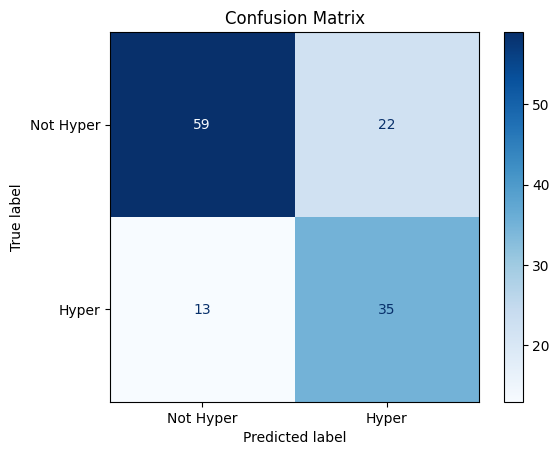

In [ ]:
#Split
X_train_text, X_test_text, y_train, y_test = split(X, y)

# Get style features
X_train_style = style_data.loc[X_train_text.index]
X_test_style = style_data.loc[X_test_text.index]

# Vectorizer
vectorizer = CountVectorizer(stop_words="english", max_features=10000)

# Combine text + style
X_train_comb, X_test_comb = combine_text_and_style(
    vectorizer,
    X_train_text, X_test_text,
    X_train_style, X_test_style
)

# Apply RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_comb, y_train)

# Train and predict on resampled data
model, y_pred = naive_bayes(X_train_resampled, X_test_comb, y_train_resampled)
y_proba = model.predict_proba(X_test_comb)[:, 1]

# Evaluate
print("\n--- Naive Bayes + CountVectorizer + Style + ROS ---")
metrics(y_test, y_pred, y_proba)
plot_confusion_matrix(y_test, y_pred)
store_metrics(results, "Naive Bayes", "CountVectorizer + Style + ROS", y_test, y_pred, y_proba)

In [ ]:
results_df = pd.DataFrame(results)
print("\n=== Final Comparison Table ===")
print(results_df)



=== Final Comparison Table ===
         Model                          Setup  Accuracy  ...  Recall  F1 Score    AUC
0  Naive Bayes                         TF-IDF     0.651  ...   0.083     0.151  0.746
1  Naive Bayes                CountVectorizer     0.690  ...   0.708     0.630  0.765
2  Naive Bayes                   TF-IDF + ROS     0.612  ...   0.854     0.621  0.811
3  Naive Bayes          CountVectorizer + ROS     0.729  ...   0.729     0.667  0.768
4  Naive Bayes  CountVectorizer + Style + ROS     0.729  ...   0.729     0.667  0.768

[5 rows x 8 columns]


TF-IDF (no ROS)

    Terrible recall (0.083), lowest F1 (0.151)

    It predicts almost no hyperpartisan articles. Not acceptable as a final baseline.

CountVectorizer (no ROS)

    Good recall (0.708), decent F1 (0.630)

    Strong simple baseline. Decent choice, but not the best.

TF-IDF + ROS massively boosts recall (0.854) but at a cost: lowest accuracy + lower F1 (0.621). But CountVectorizer (with or without style) consistently outperforms TF-IDF in Naive Bayes.


As seen from the table, results for ROS or ROS + Style are identical. This is exactly what we expected:

    It’s a bag-of-words model

    It assumes discrete integer counts

    It doesn’t know what to do with scaled float features like 0.13 exclamation_count

Therefore we add, CountVectorizer + ROS to our final-comparison baseline table.

In [112]:
result = [row for row in results if row["Setup"] == "CountVectorizer + ROS"]
df_single = pd.DataFrame(result)
df_single.to_csv("byarticleBaseline_results.csv", index=False)